# Galaxy LSTM Benchmarking Suite

This notebook evaluates the performance of the trained Galaxy Tool Prediction LSTM model.

### Objectives:
- Load the trained model and vocabulary.
- **Load Fixed Test Set**: Use the pre-generated `sample_workflow_sequences.json` (20 samples).
- **Detailed Analysis**: Inspect model predictions vs actual tools for every sample.
- Calculate specific metrics: **Precision, Recall, Hit@5, MRR**.
- Save results to `benchmarking/results/benchmark_results.json`.

### Setup Environment

In [1]:
import os
import sys
import json
import glob
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score

# Set project root
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


###  Load Data & Vocabulary


In [2]:
# 1. Load Data & Config
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_DIR = PROJECT_ROOT / "Outputs"
BENCHMARK_RESULTS_DIR = Path("results")
BENCHMARK_RESULTS_DIR.mkdir(exist_ok=True)

# Load Vocabulary
vocab_path = PROCESSED_DATA_DIR / "vocab.json"
with open(vocab_path, "r") as f:
    vocab_dict = json.load(f)
    stoi = vocab_dict["stoi"]
    itos = {int(k): v for k, v in vocab_dict["itos"].items()}

PAD_IDX = stoi.get("<PAD>", 0)
UNK_IDX = stoi.get("<UNK>", 0)
VOCAB_SIZE = len(stoi)

print(f"Vocabulary loaded: {VOCAB_SIZE} tokens")

Vocabulary loaded: 1522 tokens


###  Load Test Samples


In [3]:
# 2. Load Simplified Sample Data (20 samples)
sample_file = "sample_workflow_sequences.json"

if not os.path.exists(sample_file):
    raise FileNotFoundError(f"{sample_file} not found.")

with open(sample_file, "r") as f:
    sample_data = json.load(f)

### Preprocess Samples


In [4]:
# 3. Preprocess for Evaluation
CONTEXT_LEN = 5
# Convert simplified samples into tensors
X_bench = []
y_bench = []

for sample in sample_data:
    ctx_tools = sample["context_tools"]
    target_tool = sample["next_tool"]
    
    # Tokenize context
    ctx_ids = [stoi.get(t, UNK_IDX) for t in ctx_tools]
    # Pad context to fixed length
    if len(ctx_ids) < CONTEXT_LEN:
        ctx_ids = [PAD_IDX] * (CONTEXT_LEN - len(ctx_ids)) + ctx_ids
    else:
        ctx_ids = ctx_ids[-CONTEXT_LEN:]
        
    target_id = stoi.get(target_tool, UNK_IDX)
    
    X_bench.append(ctx_ids)
    y_bench.append(target_id)

X_tensor = torch.tensor(X_bench, dtype=torch.long)
y_tensor = torch.tensor(y_bench, dtype=torch.long)

print(f"Tensor shapes: X={X_tensor.shape}, y={y_tensor.shape}")

Tensor shapes: X=torch.Size([20, 5]), y=torch.Size([20])


###  Load Trained Model


In [5]:
# 4. Load Model
class GalaxyPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0, 
                            bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1, :])
        return self.fc(out)

# Find latest model (including improved "best_" models)
# We prioritize 'best_galaxy_lstm_*.pth' if it exists, otherwise use standard timestamped ones
best_models = sorted(glob.glob(str(MODEL_DIR / "best_galaxy_lstm_*.pth")))
standard_models = sorted(glob.glob(str(MODEL_DIR / "galaxy_lstm_*.pth")))

if best_models:
    latest_model_path = best_models[-1]
elif standard_models:
    latest_model_path = standard_models[-1]
else:
    raise FileNotFoundError("No trained model found!")

print(f"Loading model: {latest_model_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model with dynamic VOCAB_SIZE
model = GalaxyPredictor(VOCAB_SIZE).to(device)
model.load_state_dict(torch.load(latest_model_path, map_location=device))
model.eval()
print("Model loaded successfully.")

Loading model: /home/henok/Desktop/Galaxy-GNN-XP-2/Outputs/best_galaxy_lstm_20260213_221606.pth
Model loaded successfully.


### Step 5: Evaluate

In [6]:
# 5. Detailed Evaluation & Metrics
def evaluate_metrics(model, x, y):
    loader = DataLoader(TensorDataset(x, y), batch_size=1)
    
    # Storage for Scikit-Learn Metrics (Top-1)
    all_targets = []
    all_preds_top1 = []
    
    # Hit Rate & MRR
    hits_5 = 0
    mrr = 0.0
    total = 0
    
    print(f"{'='*120}")
    print(f"{'ID':<3} | {'Actual Tool':<25} | {'Top-3 Predictions':<60} | {'Hit@5?':<6} | {'Rank':<4}")
    print(f"{'='*120}")

    with torch.no_grad():
        for idx, (bx, by) in enumerate(loader):
            bx = bx.to(device)
            logits = model(bx)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            
            target_id = by.item()
            total += 1
            
            # Ranks for Hits/MRR
            sorted_indices = np.argsort(probs)[::-1]
            
            # Top-1 Prediction for Precision/Recall
            top1_id = sorted_indices[0]
            
            all_targets.append(target_id)
            all_preds_top1.append(top1_id)
            
            # Hit@5
            if target_id in sorted_indices[:5]:
                hits_5 += 1
                is_hit = "YES"
            else:
                is_hit = "NO"
            
            # MRR
            if target_id in sorted_indices:
                rank_idx = np.where(sorted_indices == target_id)[0][0]
                mrr += 1.0 / (rank_idx + 1)
                rank_display = rank_idx + 1
            else:
                rank_display = ">1k"
            
            # Display Details (Top 3)
            actual_name = itos.get(target_id, "<UNK>")
            top_3_names = [itos.get(i, "<UNK>") for i in sorted_indices[:3]]
            
            # Format top-3 display
            top3_str = ", ".join(top_3_names)
            
            # Truncate for table
            act_trim = (actual_name[:23] + '..') if len(actual_name) > 25 else actual_name
            top3_trim = (top3_str[:57] + '..') if len(top3_str) > 60 else top3_str
            
            print(f"{idx+1:<3} | {act_trim:<25} | {top3_trim:<60} | {is_hit:<6} | {rank_display:<4}")

    print(f"{'='*120}")
    
    # Calculate Metrics
    precision = precision_score(all_targets, all_preds_top1, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds_top1, average='weighted', zero_division=0)
    hit_5_score = hits_5 / total
    mrr_score = mrr / total
    
    return {
        "Precision": precision,
        "Recall": recall,
        "Hit@5": hit_5_score,
        "MRR": mrr_score
    }

print("\n--- Evaluation --- ")
metrics = evaluate_metrics(model, X_tensor, y_tensor)

results = {
    "model": Path(latest_model_path).name,
    "samples": len(X_tensor),
    **metrics
}

print("\n--- Final Benchmark Results ---")
print(json.dumps(results, indent=2))


--- Evaluation --- 
ID  | Actual Tool               | Top-3 Predictions                                            | Hit@5? | Rank
1   | eggNOG Mapper             | Sanntis biosynthetic gene clusters, XTandemAdapter, GROMA..  | NO     | 618 
2   | Join two Datasets         | Join two Datasets, Table Compute, Manipulate AnnData         | YES    | 1   
3   | MGnify amplicon summary.. | real.cwl, hicInfo, bed to protein map                        | NO     | 8   
4   | Inspect AnnData           | Plot, Inspect AnnData, Text reformatting                     | YES    | 2   
5   | Busco                     | Busco, OMArk, compleasm                                      | YES    | 1   
6   | MuSiC Deconvolution       | MuSiC Deconvolution, Inspect Expression Set Object, Const..  | YES    | 1   
7   | Convert                   | Parse parameter value, Convert, GFA to FASTA                 | YES    | 2   
8   | MultiQC                   | MultiQC, Stacks2: populations, Text transformation       

###  Save Results & Visualize


Results saved to results/benchmark_results.json


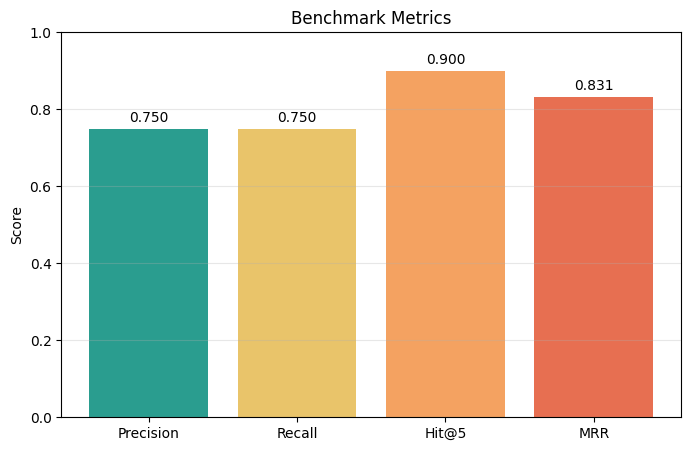

In [7]:
# 6. Save & Plot
# Save JSON
output_file = BENCHMARK_RESULTS_DIR / "benchmark_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {output_file}")

# Plot Metrics Bar Chart
metrics_names = list(metrics.keys())
metrics_vals = list(metrics.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_vals, color=['#2a9d8f', '#e9c46a', '#f4a261', '#e76f51'])
plt.title('Benchmark Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.savefig(BENCHMARK_RESULTS_DIR / "metrics_plot.png")
plt.show()